Using the prebuilt ReAct agent, the create_react_agent function in the langraph library is a great way to get started, but sometimes you might want more control and customization. In those cases, you can create a custom ReAct agent. This guide shows how to implement ReAct agent from scratch using LangGraph.

# Setup

First, let's install the required packages and set our API keys:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("NVIDIA_API_KEY")

NVIDIA_API_KEY: ··········


# Create ReAct agent
Now that you have installed the required packages and set your environment variables, we can code our ReAct agent!

# Define graph state
We are going to define the most basic ReAct state in this example, which will just contain a list of messages.

For your specific use case, feel free to add any other state keys that you need.

In [ ]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define model and tools
Next, let's define the tools and model we will use for our example.

In [ ]:
!pip install langchain-nvidia-ai-endpoints

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_nvidia_ai_endpoints import ChatNVIDIA


llm = ChatNVIDIA(
    model="meta/llama-4-scout-17b-16e-instruct",
    # api_key=<NVIDIA_API_KEY>,
    temperature=0.2,
)


from langchain.tools import tool
import requests
from bs4 import BeautifulSoup
import regex as re

@tool
def get_sentences_from_sentencedict(words:list):
    """
    Get a list of search words and Retrieve sentences for each word from sentencedict.com by fully mimicking browser behavior.
    for each word, It includes a list of sentences or an error message in the output list.
    input: list
    output: list of list
    """
    base_url = "https://sentencedict.com/wordQueryDo.php"

    # Set up a session to persist cookies
    session = requests.Session()

    # 1. First, visit the homepage to set initial cookies
    home_url = "https://sentencedict.com/"
    session.get(home_url, headers={
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://www.google.com/",
    })

    # 2. Submit the search query with proper headers & cookies
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Content-Type": "application/x-www-form-urlencoded",
        "Origin": "https://sentencedict.com",
        "Referer": "https://sentencedict.com/",  # Updated to match actual referer
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "same-origin",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
    }

    searching_results = []
    for word in words:
      # The website expects `word` (not `query`) as the parameter name!
      data = {"word": word, "directGo": "1"}  # Critical: Forces direct results

      try:
          response = session.post(
              base_url,
              headers=headers,
              data=data,
          )
          response.raise_for_status()
          # print(response.text)
          # return

          soup = BeautifulSoup(response.text, "html.parser")

          # Find the content div that contains all sentences
          content_div = soup.find('div', id='content')

          sentences = []
          if content_div:
              # Extract all sentence divs (they're direct children of content_div)
              sentence_divs = content_div.find_all('div', recursive=False)

              for div in sentence_divs:
                  text = div.get_text(strip=False)
                  # Skip if text contains "Synonym:", "Meaning:", or "Random good picture"
                  if any(x in text for x in ["Synonym:", "Meaning:", "Random good picture", 'More similar words:']):
                      continue
                  # Skip empty strings
                  if not text:
                      continue
                  sentences.append(text.strip())

          # If the senetences varible is not full of sentences
          if not sentences:
              searching_results.append("No sentences found")
              continue
              # return {"error": "No sentences found in the expected format."}

          number_pattern = re.compile('\d+\.\s|\(\d+\)\s')
          first_item = re.split(number_pattern, sentences[0])
          # variable's items contain more than one sentence
          if len(first_item) > 2:
              sentences = [f"{i}. {sentence.strip()}" for i, sentence in enumerate(first_item) if sentence]
          # variable's items contain one sentence
          elif len(first_item) == 2:
              sentences = [f"{i}. {re.split(number_pattern, sentence)[1].strip()}" for i, sentence in enumerate(sentences, start=1) if sentence]

          searching_results.append(sentences)
          # return {"sentences": sentences}

      except Exception as e:
          searching_results.append("Error")
          # return {"error": f"Unexpected error: {str(e)}", "raw_response": response.text}

    return searching_results


tools = [get_sentences_from_sentencedict]

llm_with_tools = llm.bind_tools(tools)

/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/_common.py:212: UserWarning: Found meta/llama-4-scout-17b-16e-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:591: UserWarning: Model 'meta/llama-4-scout-17b-16e-instruct' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


# Define nodes and edges
Next let's define our nodes and edges. In our basic ReAct agent there are only two nodes, one for calling the model and one for using tools, however you can modify this basic structure to work better for your use case. The tool node we define here is a simplified version of the prebuilt ToolNode, which has some additional features.

Perhaps you want to add a node for adding structured output or a node for executing some external action (sending an email, adding a calendar event, etc.). Maybe you just want to change the way the call_model node works and how should_continue decides whether to call tools - the possibilities are endless and LangGraph makes it easy to customize this basic structure for your specific use case.

In [ ]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = f"""You are a helpful English tutor that creates example sentences"""
    response = llm_with_tools.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define the graph
Now that we have defined all of our nodes and edges, we can define and compile our graph. Depending on if you have added more nodes or different edges, you will need to edit this to fit your specific use case.

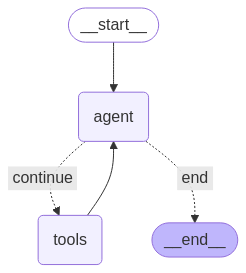

In [ ]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
# workflow.add_node("LLM", call_model)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")
workflow
# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Use ReAct agent
Now that we have created our react agent, let's actually put it to the test!

In [ ]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

words = "['Reservation', 'Could I have', 'a dinner reservation']"
instructions = f"""Process the words delimited by triple backticks with the following rules STRICTLY:
1. Processing methods:
- If the tool returns `No sentences found` for a word, YOU MUST generate and return 10 NEW sentences for that word only
- If the tool returns sentences for a word, include all of them EXACTLY
- If the tool returns `Error` for a word, write 'Something went wrong.' for that word only
2. Format the output EXACTLY as shown below

use the following format for the output:
- <word>
1. <sentence 1>
2. <sentence 2>
...
----------------

Words: ```{words}``

output:

"""
user_prompt = instructions + f"Words: ```{words}```"

inputs = {"messages": [("user", user_prompt)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Process the words delimited by triple backticks with the following rules STRICTLY:
1. Processing methods:
- If the tool returns `No sentences found` for a word , YOU MUST generate and return 10 NEW sentences for that word only
- If the tool returns sentences for a word, include all of them EXACTLY
- If the tool returns `Error` for a word, write 'Something went wrong.' for that word only
2. Format the output EXACTLY as shown below

use the following format for the output:
- <word>
1. <sentence 1>
2. <sentence 2>
...
----------------

Words: ```['Reservation', 'Could I have', 'a dinner reservation']``

output:

Words: ```['Reservation', 'Could I have', 'a dinner reservation']```
================================== Ai Message ==================================
Tool Calls:
  get_sentences_from_sentencedict (chatcmpl-tool-63c5d422065e4f9b963802fcefb10965)
 Call ID: chatcmpl-tool-63c5d422065e4f9b963802fcefb10965